In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
base = pd.read_csv(r"C:\Users\mmelgar\Desktop\Cursoml\Semana 2\archive\housing.csv",sep=',',encoding='latin-1') # Importo el dataset seleccionado en cuestión.

In [5]:
base2 = base[['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value','ocean_proximity']]
base2.total_bedrooms = base2.total_bedrooms.fillna(0)

In [6]:
base2.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
df_full_train, df_test = train_test_split(base2, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [13]:
len(df_train),len(df_val),len(df_test)

(12384, 4128, 4128)

In [9]:
features = [
'longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','ocean_proximity'
]


In [10]:
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [20]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [21]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [23]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



In [24]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [25]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24573834331838426

In [26]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
df_scores

,n_estimators,rmse
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104
5,60,0.232843
6,70,0.232384
7,80,0.232527
8,90,0.232215
9,100,0.231968


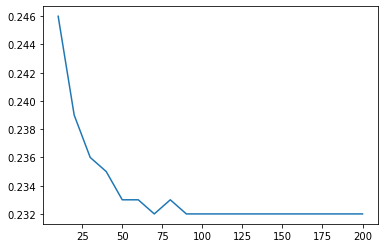

In [28]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [29]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.255042
1,10,20,0.252784
2,10,30,0.251647
3,10,40,0.251062
4,10,50,0.250192
...,...,...,...
75,25,160,0.231484
76,25,170,0.231440
77,25,180,0.231598
78,25,190,0.231603


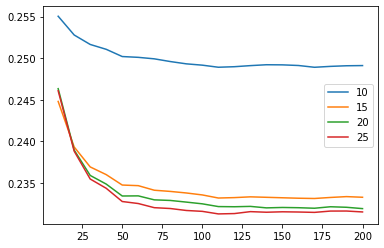

In [31]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

In [32]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [33]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances

C:\Users\mmelgar\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,households,0.016957
1,housing_median_age,0.033094
2,latitude,0.101334
3,longitude,0.096265
4,median_income,0.362913
5,ocean_proximity=<1H OCEAN,0.003007
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000449
9,ocean_proximity=NEAR OCEAN,0.004228


In [62]:
features = dv.get_feature_names()
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


C:\Users\mmelgar\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [63]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [72]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [73]:
parse_xgb_output(output)

,num_iter,train_auc,val_auc
0,0,10.44372,10.44938
1,5,6.17513,6.17987
2,10,3.65741,3.66135
3,15,2.17500,2.17928
4,20,1.30499,1.31054
5,25,0.79933,0.80657
6,30,0.51144,0.52189
7,35,0.35700,0.37264
8,40,0.27984,0.30053
9,45,0.24350,0.26829


In [90]:
scores2 = {}

In [99]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [100]:
scores2[0.3] = parse_xgb_output(output)

In [103]:
scores2

{0.3:     num_iter  train_auc  val_auc
 0          0    8.12733  8.13245
 1          5    1.40218  1.40741
 2         10    0.34481  0.35782
 3         15    0.23555  0.26044
 4         20    0.21580  0.24624
 5         25    0.20395  0.24099
 6         30    0.19440  0.23741
 7         35    0.18637  0.23562
 8         40    0.17983  0.23419
 9         45    0.17468  0.23279
 10        50    0.16934  0.23097
 11        55    0.16546  0.23039
 12        60    0.16177  0.22950
 13        65    0.15762  0.22857
 14        70    0.15323  0.22787
 15        75    0.15010  0.22755
 16        80    0.14564  0.22611
 17        85    0.14166  0.22579
 18        90    0.13892  0.22628
 19        95    0.13553  0.22630
 20        99    0.13299  0.22610,
 0.1:     num_iter  train_auc   val_auc
 0          0   10.44372  10.44938
 1          5    6.17513   6.17987
 2         10    3.65741   3.66135
 3         15    2.17500   2.17928
 4         20    1.30499   1.31054
 5         25    0.79933   0.80

In [96]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [97]:
scores2[0.1] = parse_xgb_output(output)

(50.0, 100.0)

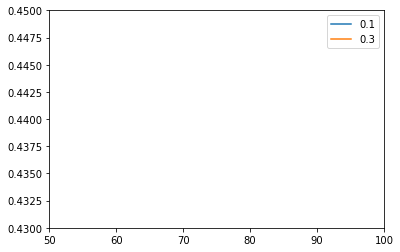

In [102]:
plt.plot(scores2[0.1].num_iter, scores2[0.1].val_auc,
        label='0.1')
plt.plot(scores2[0.3].num_iter, scores2[0.3].val_auc,
        label='0.3')
plt.legend()

plt.ylim([0.43, 0.45])
plt.xlim([50, 100])